In [47]:
import numpy as np
import pandas as pd
import datetime as dt
import urllib.request as urlreq
import json
import os
#os.chdir('.\ModelWeights')

from matplotlib import pyplot
pd.options.display.float_format = '{:,.4f}'.format
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dropout

In [2]:
### Collecting VIX and SPX index data from CBOE and Yahoo Finance

# VIX Data Collection
curr_vix = pd.read_csv('http://www.cboe.com/publish/scheduledtask/mktdata/datahouse/vixcurrent.csv', 
                       skiprows = 1, index_col = 0)
curr_vix.index = pd.to_datetime(curr_vix.index)

hist_vix = pd.read_excel('http://www.cboe.com/publish/scheduledtask/mktdata/datahouse/vixarchive.xls',
                         skiprows = 1, index_col = 0)
hist_vix.index = pd.to_datetime(hist_vix.index)

vix = pd.concat([hist_vix,curr_vix], axis = 0)

# SPX Data Collection
ticker = '^GSPC'
start_date = dt.datetime(1990,1,1)
end_date = end_date = dt.datetime.today()

start_date_unix = int(start_date.timestamp())
end_date_unix = int(end_date.timestamp())

hist_price_url = 'https://query1.finance.yahoo.com/v8/finance/chart/{0}?symbol={0}&period1={1}&period2={2}&interval=1d'.format(ticker,start_date_unix,end_date_unix)

with urlreq.urlopen(hist_price_url) as url:
    data = json.loads(url.read().decode())
    hist_prices = pd.DataFrame({**data['chart']['result'][0]['indicators']['quote'][0], **data['chart']['result'][0]['indicators']['adjclose'][0]},
                               index = [dt.datetime.utcfromtimestamp(int(x)).date() for x in data['chart']['result'][0]['timestamp']])
    hist_prices.index = pd.to_datetime(hist_prices.index)
    hist_prices.columns = ["{0}_{1}".format(ticker.replace('^',''), x) for x in hist_prices.columns]


In [24]:
# Joining both VIX and SPX data into one dataframe and backfilling null values
data = pd.concat([hist_prices[['GSPC_close']], vix[['VIX Close']]], 
                 axis = 1).replace('n/a',np.nan).apply(lambda x: pd.to_numeric(x)).fillna(method = 'ffill')
data.columns = [col.replace(' ','_') for col in data.columns.tolist()]

# Dividing VIX_Close by 100 given the index is a measure of implied future volatility
data['VIX_Close'] = data['VIX_Close']/100

# Calculating 20 Trading Day Rolling Realized Annualized Volatility for the SPX Index

data['RV'] = np.log(data['GSPC_close']/data['GSPC_close'].shift(1)).rolling(window = 20).std()*np.sqrt(252)

# Returns for 20 Day for the SPX Index
data['Return_20D'] = data.GSPC_close.pct_change(20)
    
# Short Period vs Long Period Simple Moving Average Measure
short_window = 20
long_window = 200
data['ShortVLongSMA'] = data.GSPC_close.rolling(window = short_window).mean()/data.GSPC_close.rolling(window = long_window).mean() - 1

data['Max_DD_Period'] = data.GSPC_close/data.GSPC_close.rolling(window = 20).max() - 1
data['Max_DD_Period'] = data['Max_DD_Period'].rolling(window = 20).min()
data = data.dropna().iloc[:,1:]

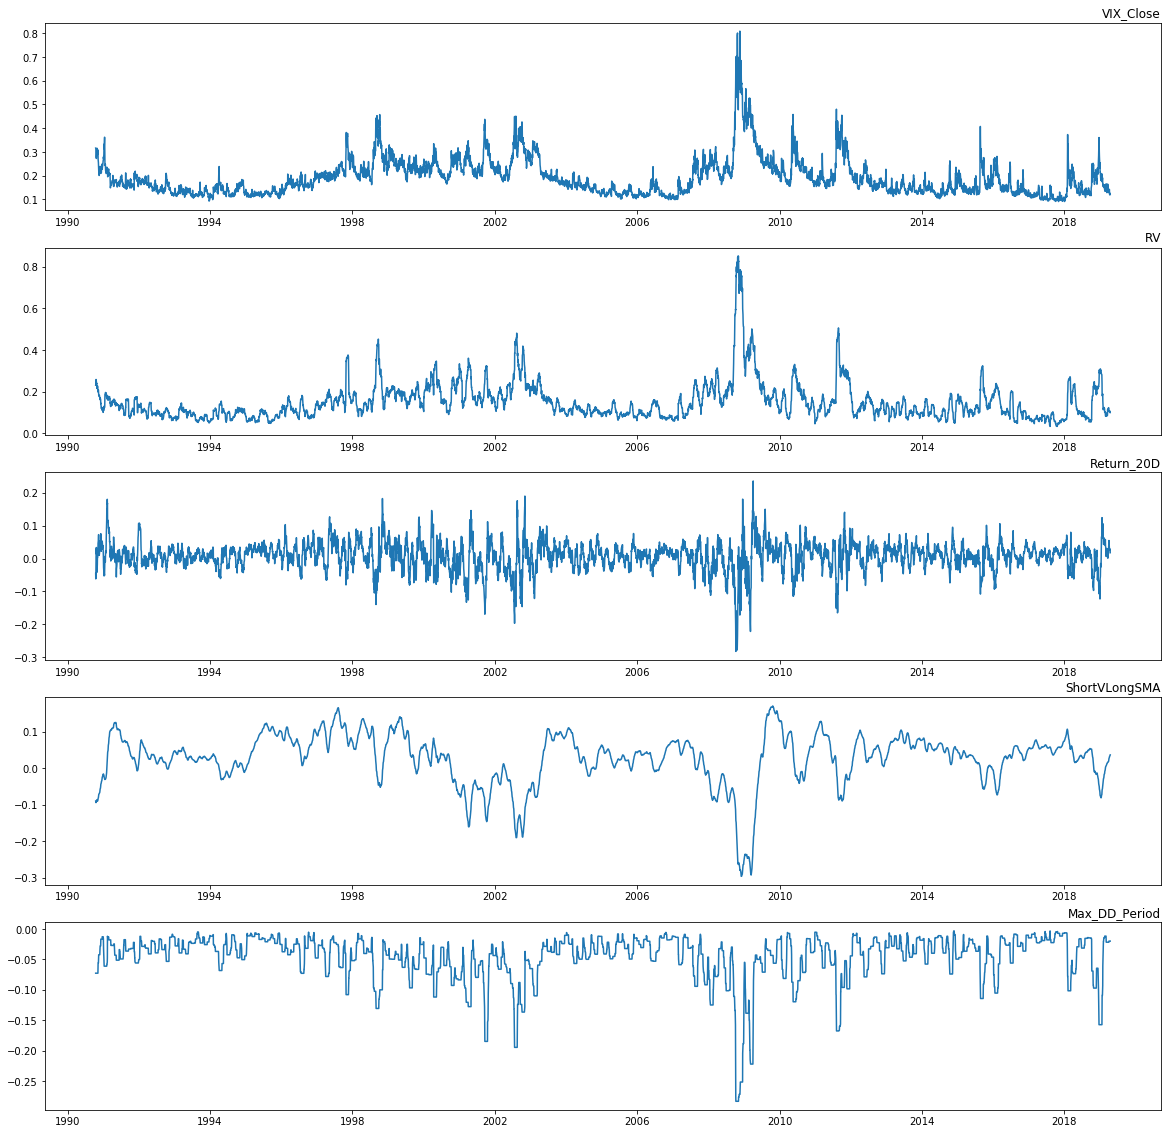

In [25]:
# Plotting Time Series of Features

pyplot.figure(figsize = (20,20))
for variable in range(data.shape[1]):
    pyplot.subplot(data.shape[1], 1, variable + 1)
    pyplot.plot(data.iloc[:, variable])
    pyplot.title(data.columns[variable], y = 1, loc = 'right')

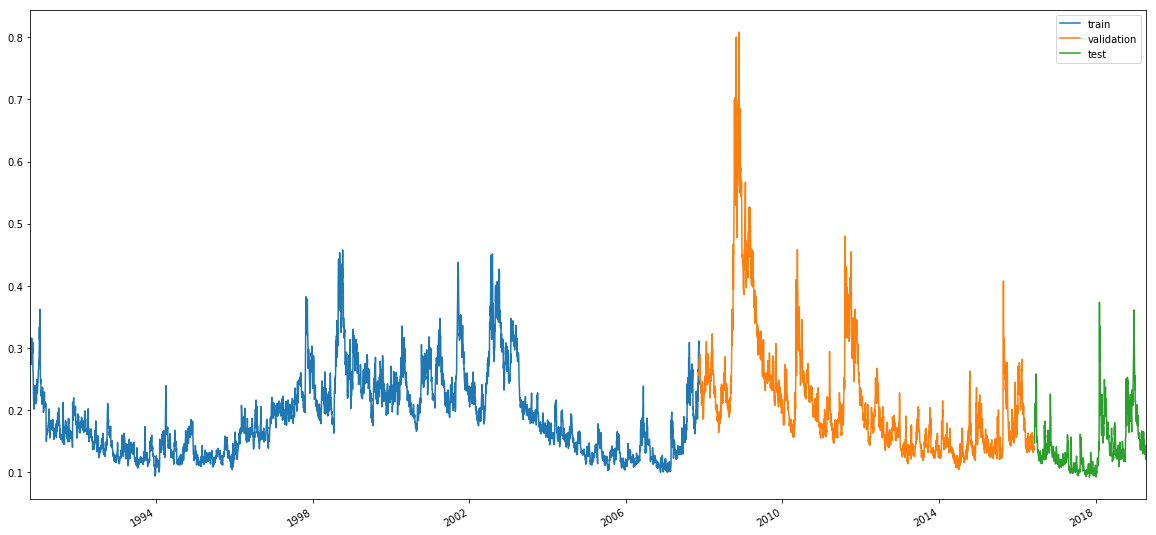

In [26]:
# LSTM Data Preparation

# Converting time series to supervised learning data
# Predicting t = 1 Day out
timesteps = 1

data['VIX_Forecast'] = data['VIX_Close'].shift(-timesteps)
lstm_data = data.dropna()

# Splitting Data into Training, Validation, and Test sets
train_pct = 0.6
validation_pct = 0.3

train = lstm_data.iloc[:round(len(lstm_data)*train_pct),:]
validation = lstm_data.iloc[len(train):len(train) + round(len(lstm_data)*validation_pct), :]
test = lstm_data[lstm_data.index > validation.index[-1]]

# Plotting the data sets
pyplot.figure(figsize=(20, 10))
ax = train.VIX_Close.plot()
validation.VIX_Close.plot(ax=ax)
test.VIX_Close.plot(ax=ax)
pyplot.legend(['train', 'validation', 'test'])

In [8]:
# Since all features are between -1 and 1 by definition, normalization is unnecessary


# Splitting into input and outputs
train_x, train_y = train.values[:, :-1], train.values[:, -1]
validation_x, validation_y = validation.values[:, :-1], validation.values[:, -1]
test_x, test_y = test.values[:, :-1], test.values[:, -1]

# Reshaping data to be 3D [samples, timesteps, features] for tensor operations

train_x = train_x.reshape((train_x.shape[0], timesteps, train_x.shape[1]))
validation_x = validation_x.reshape((validation_x.shape[0], timesteps, validation_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], timesteps, test_x.shape[1]))
print(train_x.shape, train_y.shape, validation_x.shape, validation_y.shape, test_x.shape, test_y.shape)

(4310, 1, 5) (4310,) (2155, 1, 5) (2155,) (719, 1, 5) (719,)


Train on 4310 samples, validate on 2155 samples
Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.14390, saving model to LSTM_mae_weights.hdf5
4310/4310 - 1s - loss: 0.1569 - val_loss: 0.1439
Epoch 2/100

Epoch 00002: val_loss improved from 0.14390 to 0.06671, saving model to LSTM_mae_weights.hdf5
4310/4310 - 0s - loss: 0.0847 - val_loss: 0.0667
Epoch 3/100

Epoch 00003: val_loss improved from 0.06671 to 0.05002, saving model to LSTM_mae_weights.hdf5
4310/4310 - 0s - loss: 0.0431 - val_loss: 0.0500
Epoch 4/100

Epoch 00004: val_loss improved from 0.05002 to 0.04723, saving model to LSTM_mae_weights.hdf5
4310/4310 - 0s - loss: 0.0416 - val_loss: 0.0472
Epoch 5/100

Epoch 00005: val_loss improved from 0.04723 to 0.04478, saving model to LSTM_mae_weights.hdf5
4310/4310 - 0s - loss: 0.0400 - val_loss: 0.0448
Epoch 6/100

Epoch 00006: val_loss improved from 0.04478 to 0.04215, saving model to LSTM_mae_weights.hdf5
4310/4310 - 0s - loss: 0.0381 - val_loss: 0.0422
Epoch 7/100

Epoch 0

Epoch 53/100

Epoch 00053: val_loss improved from 0.01880 to 0.01864, saving model to LSTM_mae_weights.hdf5
4310/4310 - 0s - loss: 0.0205 - val_loss: 0.0186
Epoch 54/100

Epoch 00054: val_loss improved from 0.01864 to 0.01848, saving model to LSTM_mae_weights.hdf5
4310/4310 - 0s - loss: 0.0203 - val_loss: 0.0185
Epoch 55/100

Epoch 00055: val_loss improved from 0.01848 to 0.01831, saving model to LSTM_mae_weights.hdf5
4310/4310 - 0s - loss: 0.0210 - val_loss: 0.0183
Epoch 56/100

Epoch 00056: val_loss improved from 0.01831 to 0.01815, saving model to LSTM_mae_weights.hdf5
4310/4310 - 0s - loss: 0.0204 - val_loss: 0.0182
Epoch 57/100

Epoch 00057: val_loss improved from 0.01815 to 0.01798, saving model to LSTM_mae_weights.hdf5
4310/4310 - 0s - loss: 0.0196 - val_loss: 0.0180
Epoch 58/100

Epoch 00058: val_loss improved from 0.01798 to 0.01777, saving model to LSTM_mae_weights.hdf5
4310/4310 - 0s - loss: 0.0202 - val_loss: 0.0178
Epoch 59/100

Epoch 00059: val_loss improved from 0.01777 

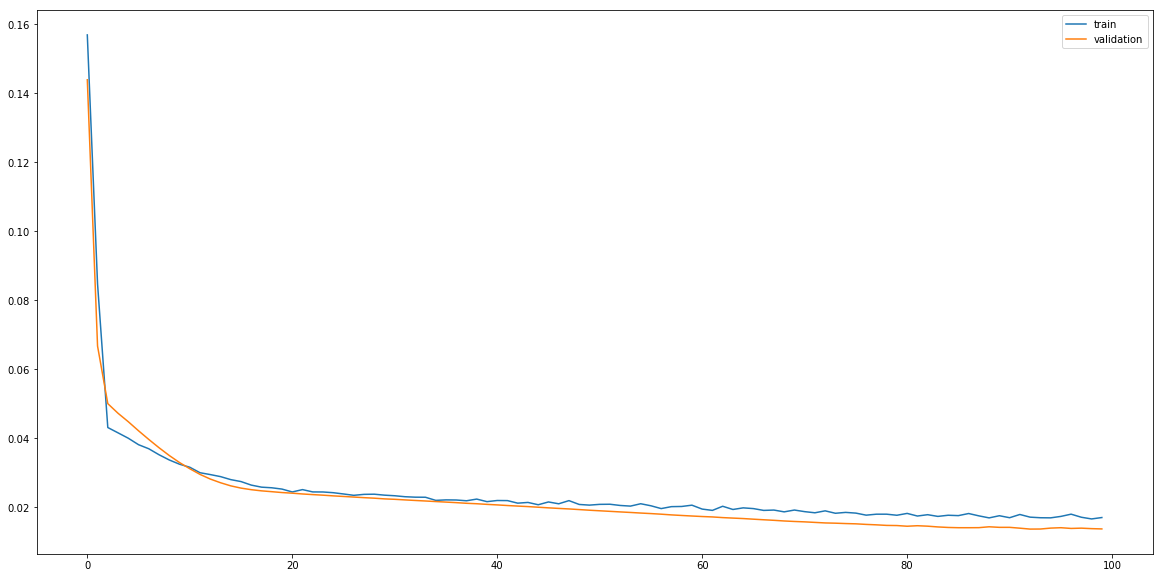

In [19]:
# design network
# 50 neurons with 100 Epochs with batch size of 200
neurons = 30
n_epochs = 100
batchsize = 200

model = Sequential()
# model.add(LSTM(neurons, input_shape=(train_x.shape[1], train_x.shape[2]), activation = 'tanh',
#                recurrent_activation='hard_sigmoid', dropout=0.1, recurrent_dropout=0.1))
model.add(LSTM(neurons, input_shape=(train_x.shape[1], train_x.shape[2]), activation = 'tanh',
               dropout=0.05))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
checkpointer = ModelCheckpoint(filepath="LSTM_mae_weights.hdf5", verbose=1, save_best_only=True)

history = model.fit(train_x, train_y, epochs = n_epochs, 
                    batch_size = batchsize, validation_data=(validation_x, validation_y), 
                    verbose=2, shuffle=False, callbacks = [checkpointer])
# plot history
pyplot.figure(figsize=(20, 10))
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

In [20]:
# make a prediction
yhat_validation = model.predict(validation_x).reshape(validation_y.shape)
yhat_test = model.predict(test_x).reshape(test_y.shape)

# calculate RMSE
rmse_validation = np.sqrt(mean_squared_error(validation_y, yhat_validation))
rmse_test = np.sqrt(mean_squared_error(test_y, yhat_test))
print('Validation RMSE: %.3f' % rmse_validation)
print('Test RMSE: %.3f' % rmse_test)

Validation RMSE: 0.022
Test RMSE: 0.016


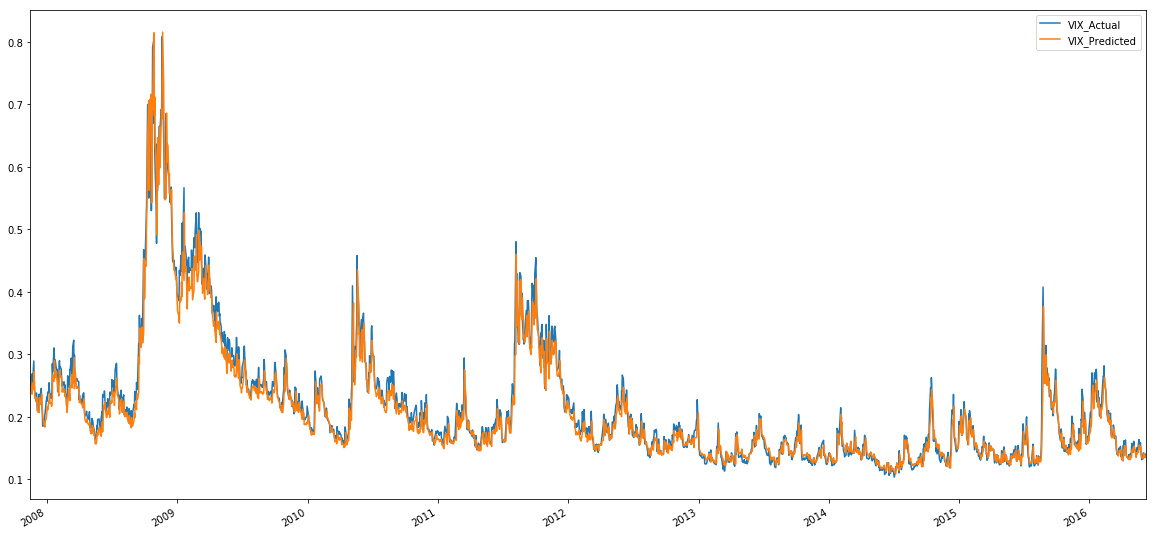

In [21]:
validation_performance = pd.DataFrame({'VIX_Actual': validation_y,
                                       'VIX_Predicted': yhat_validation}).set_index(validation.index).shift(1).dropna()
validation_performance.plot(figsize = (20,10))

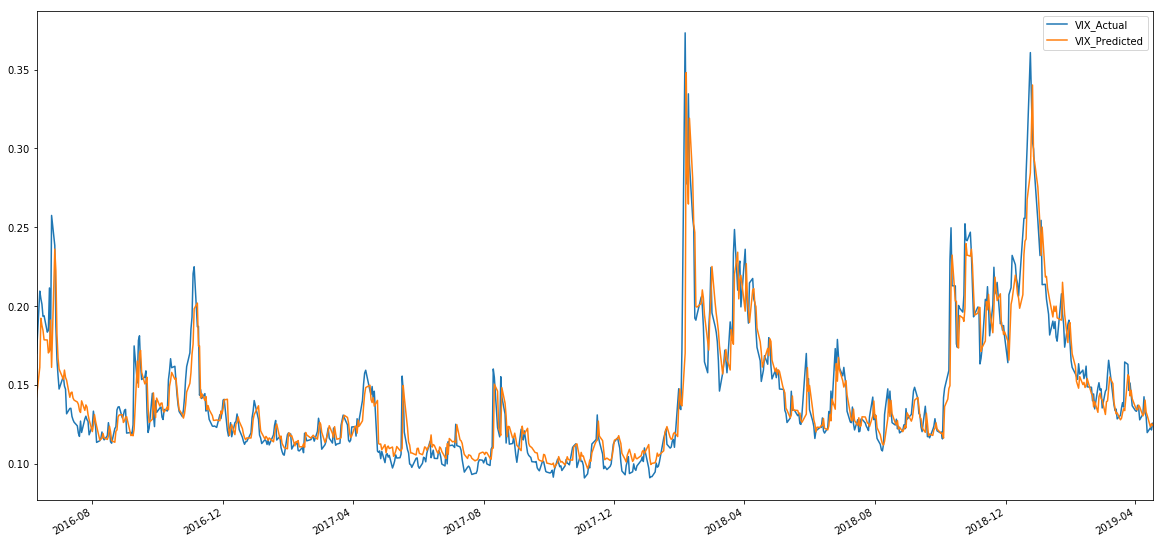

In [22]:
test_performance = pd.DataFrame({'VIX_Actual': test_y,
                                 'VIX_Predicted': yhat_test}).set_index(test.index).shift(1).dropna()
test_performance.plot(figsize = (20,10))

In [32]:
# Using Simple MLP to predict 20 day out
simplenn_timesteps = 20
simplenn = data.iloc[:,:-1]
simplenn['VIX_Forecast'] = simplenn['VIX_Close'].shift(-simplenn_timesteps)
simplenn = simplenn.dropna()

In [38]:
# Splitting Data into Training, Validation, and Test sets
train_mlp = simplenn.iloc[:round(len(simplenn)*train_pct),:]
validation_mlp = simplenn.iloc[len(train_mlp):len(train_mlp) + round(len(simplenn)*validation_pct), :]
test_mlp = simplenn[simplenn.index > validation_mlp.index[-1]]

# Since all features are between -1 and 1 by definition, normalization is unnecessary

# Splitting into input and outputs
train_mlp_x, train_mlp_y = train_mlp.values[:, :-1], train_mlp.values[:, -1]
validation_mlp_x, validation_mlp_y = validation_mlp.values[:, :-1], validation_mlp.values[:, -1]
test_mlp_x, test_mlp_y = test_mlp.values[:, :-1], test_mlp.values[:, -1]

# No need to reshape
print(train_mlp_x.shape, train_mlp_y.shape, validation_mlp_x.shape, validation_mlp_y.shape, test_mlp_x.shape, test_mlp_y.shape)

(4299, 5) (4299,) (2150, 5) (2150,) (716, 5) (716,)


Train on 4299 samples, validate on 2150 samples
Epoch 1/100

Epoch 00001: val_loss did not improve from 0.01366
4299/4299 - 0s - loss: 0.1016 - val_loss: 0.0476
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.01366
4299/4299 - 0s - loss: 0.0449 - val_loss: 0.0451
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.01366
4299/4299 - 0s - loss: 0.0429 - val_loss: 0.0431
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.01366
4299/4299 - 0s - loss: 0.0389 - val_loss: 0.0428
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.01366
4299/4299 - 0s - loss: 0.0371 - val_loss: 0.0419
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.01366
4299/4299 - 0s - loss: 0.0351 - val_loss: 0.0413
Epoch 7/100

Epoch 00007: val_loss did not improve from 0.01366
4299/4299 - 0s - loss: 0.0337 - val_loss: 0.0406
Epoch 8/100

Epoch 00008: val_loss did not improve from 0.01366
4299/4299 - 0s - loss: 0.0325 - val_loss: 0.0399
Epoch 9/100

Epoch 00009: val_loss did not impro

Epoch 73/100

Epoch 00073: val_loss did not improve from 0.01366
4299/4299 - 0s - loss: 0.0247 - val_loss: 0.0360
Epoch 74/100

Epoch 00074: val_loss did not improve from 0.01366
4299/4299 - 0s - loss: 0.0247 - val_loss: 0.0360
Epoch 75/100

Epoch 00075: val_loss did not improve from 0.01366
4299/4299 - 0s - loss: 0.0247 - val_loss: 0.0360
Epoch 76/100

Epoch 00076: val_loss did not improve from 0.01366
4299/4299 - 0s - loss: 0.0247 - val_loss: 0.0360
Epoch 77/100

Epoch 00077: val_loss did not improve from 0.01366
4299/4299 - 0s - loss: 0.0247 - val_loss: 0.0360
Epoch 78/100

Epoch 00078: val_loss did not improve from 0.01366
4299/4299 - 0s - loss: 0.0247 - val_loss: 0.0360
Epoch 79/100

Epoch 00079: val_loss did not improve from 0.01366
4299/4299 - 0s - loss: 0.0247 - val_loss: 0.0360
Epoch 80/100

Epoch 00080: val_loss did not improve from 0.01366
4299/4299 - 0s - loss: 0.0247 - val_loss: 0.0360
Epoch 81/100

Epoch 00081: val_loss did not improve from 0.01366
4299/4299 - 0s - loss: 

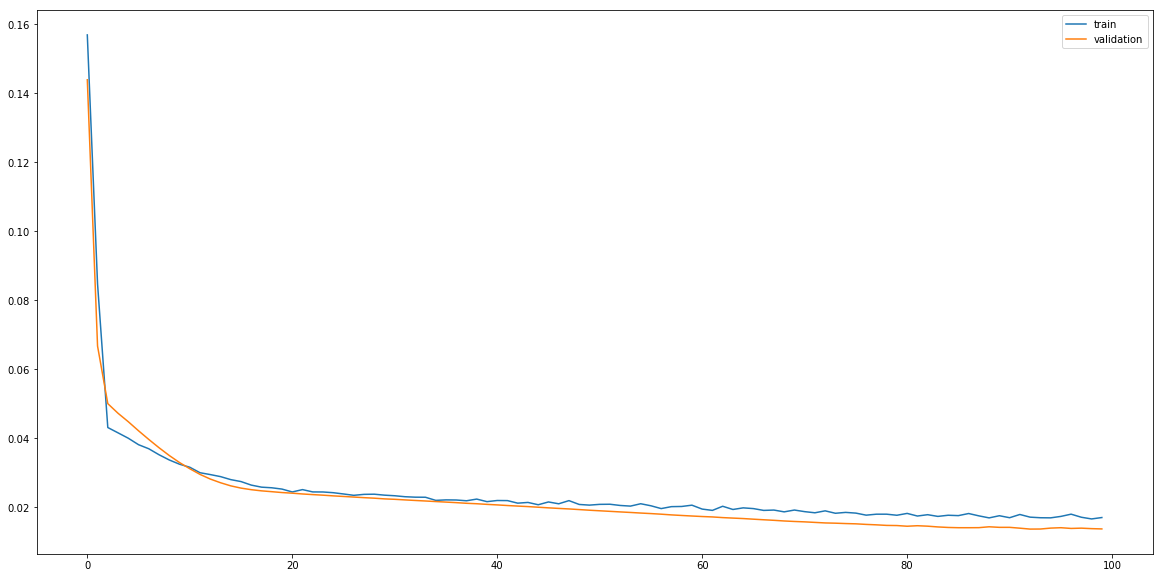

In [48]:
# design network
# 100 Epochs with batch size of 200

model_mlp = Sequential()
model_mlp.add(Dense(13, input_dim = train_mlp_x.shape[1], activation = 'tanh'))
model.add(Dropout(0.1))
model_mlp.add(Dense(6, activation = 'relu'))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mae', optimizer='adam')
# fit network
checkpointer_mlp = ModelCheckpoint(filepath="MLP_mae_weights.hdf5", verbose=1, save_best_only=True)

history_mlp = model_mlp.fit(train_mlp_x, train_mlp_y, epochs = n_epochs, 
                            batch_size = batchsize, validation_data=(validation_mlp_x, validation_mlp_y), 
                            verbose=2, shuffle=False, callbacks = [checkpointer])
# plot history
pyplot.figure(figsize=(20, 10))
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

In [51]:
# make a prediction
yhat_mlp_validation = model_mlp.predict(validation_mlp_x).reshape(validation_mlp_y.shape)
yhat_mlp_test = model_mlp.predict(test_mlp_x).reshape(test_mlp_y.shape)

# calculate RMSE
rmse_mlp_validation = np.sqrt(mean_squared_error(validation_mlp_y, yhat_mlp_validation))
rmse_mlp_test = np.sqrt(mean_squared_error(test_mlp_y, yhat_mlp_test))
print('Validation RMSE: %.3f' % rmse_mlp_validation)
print('Test RMSE: %.3f' % rmse_mlp_test)

Validation RMSE: 0.059
Test RMSE: 0.041


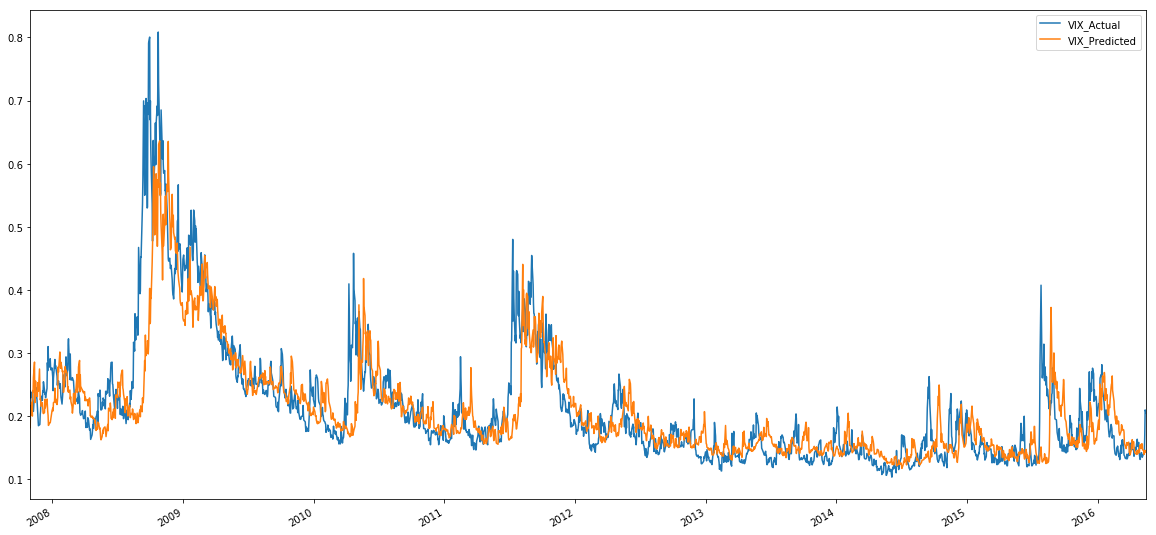

In [52]:
validation_mlp_performance = pd.DataFrame({'VIX_Actual': validation_mlp_y,
                                           'VIX_Predicted': yhat_mlp_validation}).set_index(validation_mlp.index)
validation_mlp_performance.plot(figsize = (20,10))

### Links
- https://www.datacamp.com/community/tutorials/lstm-python-stock-market
- https://codeburst.io/neural-networks-for-algorithmic-trading-volatility-forecasting-and-custom-loss-functions-c030e316ea7e
- https://medium.com/@alexrachnog/neural-networks-for-algorithmic-trading-part-one-simple-time-series-forecasting-f992daa1045a
- https://towardsdatascience.com/an-introduction-on-time-series-forecasting-with-simple-neura-networks-lstm-f788390915b
- https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
- https://github.com/guillaume-chevalier/seq2seq-signal-prediction
- https://gist.github.com/lukovkin/1aefa4509e066690b892
- https://medium.com/datadriveninvestor/multivariate-time-series-using-rnn-with-keras-7f78f4488679